In [4]:
!pip install pmdarima yfinance tensorflow scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


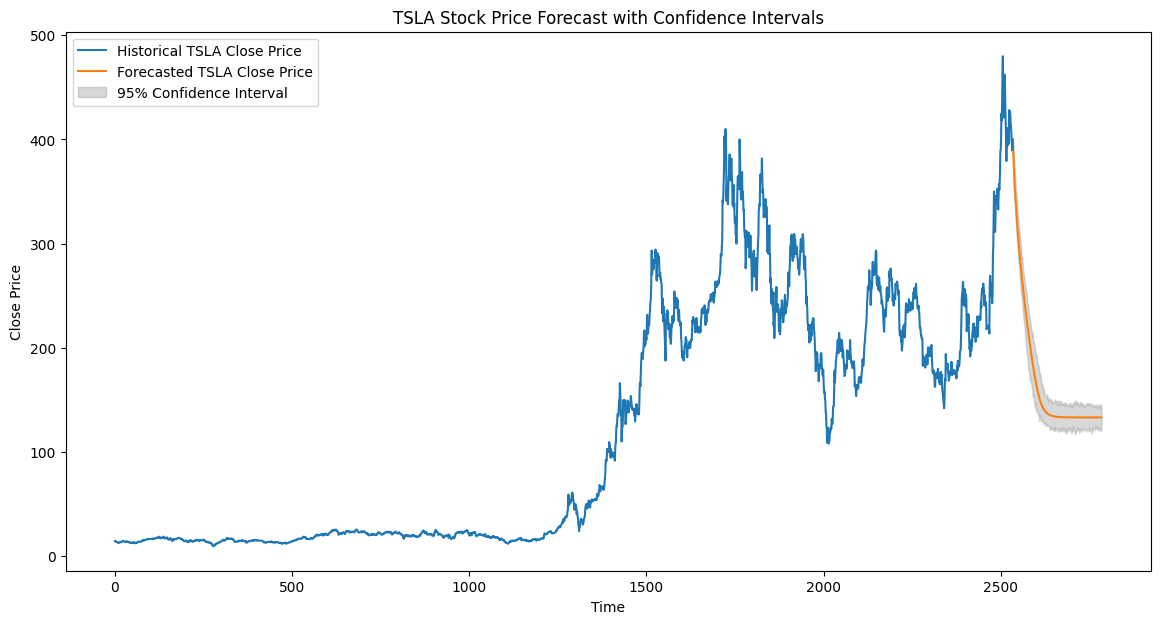

Forecast: [[388.27023]
 [381.99344]
 [372.69827]
 [364.2734 ]
 [357.32822]
 [351.52933]
 [346.1854 ]
 [340.9507 ]
 [335.7886 ]
 [330.66714]
 [325.6587 ]
 [320.84744]
 [316.2284 ]
 [311.78677]
 [307.49582]
 [303.33127]
 [299.27682]
 [295.3235 ]
 [291.46655]
 [287.70068]
 [284.0213 ]
 [280.42456]
 [276.90335]
 [273.4534 ]
 [270.07663]
 [266.76517]
 [263.5107 ]
 [260.3105 ]
 [257.15967]
 [254.06042]
 [251.01245]
 [248.00749]
 [245.04305]
 [242.11589]
 [239.23553]
 [236.39955]
 [233.60559]
 [230.8425 ]
 [228.1028 ]
 [225.3884 ]
 [222.69444]
 [220.01534]
 [217.3562 ]
 [214.72195]
 [212.1106 ]
 [209.52151]
 [206.95317]
 [204.41266]
 [201.9063 ]
 [199.43301]
 [196.99275]
 [194.5888 ]
 [192.2202 ]
 [189.88802]
 [187.59036]
 [185.3299 ]
 [183.11427]
 [180.94179]
 [178.80936]
 [176.72621]
 [174.6945 ]
 [172.7123 ]
 [170.78026]
 [168.90112]
 [167.07841]
 [165.31712]
 [163.61826]
 [161.97145]
 [160.37634]
 [158.8271 ]
 [157.3318 ]
 [155.88972]
 [154.50467]
 [153.18236]
 [151.92517]
 [150.73909]
 [

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
import datetime

warnings.filterwarnings("ignore", category=FutureWarning)

# Assuming you have loaded your data into data_dict as in the previous steps
# If not, use the data_loader.py to load your data.
def load_and_clean_data(tickers, start_date, end_date):
    """Loads and cleans financial data for given tickers."""
    data_dict = {}
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data is not None and not data.empty:
            # Flatten MultiIndex columns
            data.columns = [col[0] for col in data.columns]
            #Use ffill() instead of fillna(method='ffill')
            data.ffill(inplace=True)
            data.index = pd.to_datetime(data.index)
            data_dict[ticker] = data
        else:
            print(f"No data found for {ticker}")
    return data_dict

def get_date_range(year_start = 2015, month_start= 1, day_start = 1, year_end = 2025, month_end = 1, day_end = 31):
    """Returns start and end datetime objects."""
    start_date = datetime.datetime(year_start, month_start, day_start)
    end_date = datetime.datetime(year_end, month_end, day_end)
    return start_date, end_date


tickers = ["TSLA"]
start_date, end_date = get_date_range()
data_dict = load_and_clean_data(tickers, start_date, end_date)
tsla_data = data_dict["TSLA"]

# 1. Data Preparation
tsla_close = tsla_data["Close"].values.reshape(-1, 1)

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_close)

# Create sequences for the entire dataset
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # You can adjust this
X, y = create_sequences(scaled_data, seq_length)

# 2. LSTM Model Refinement

# (a) Add more layers and neurons
lstm_model = keras.Sequential([
    layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

# (b) Add Dropout for regularization
lstm_model = keras.Sequential([
    layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    layers.Dropout(0.2),  # Adjust dropout rate as needed
    layers.LSTM(50, activation='relu'),
    layers.Dropout(0.2),  # Adjust dropout rate as needed
    layers.Dense(1)
])

# (c) Experiment with different optimizers and learning rates
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Adjust learning rate
lstm_model.compile(optimizer=optimizer, loss='mse')

# 3. Train the Model
lstm_model.fit(X, y, epochs=100, batch_size=32, verbose=0)  # Adjust epochs and batch size

# 4. Generate Forecasts
forecast_period = 250  # Approximately 1 year of trading days
forecast = []
current_seq = scaled_data[-seq_length:].reshape(1, seq_length, 1)

for _ in range(forecast_period):
    prediction = lstm_model.predict(current_seq, verbose=0)
    forecast.append(prediction[0, 0])
    current_seq = np.append(current_seq[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse scale the forecasts
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# 5. Estimate Confidence Intervals (Simulation Approach)
num_simulations = 100  # Adjust as needed
all_forecasts = []

for _ in range(num_simulations):
    simulated_forecast = []
    simulated_seq = scaled_data[-seq_length:].reshape(1, seq_length, 1)
    for _ in range(forecast_period):
        prediction = lstm_model.predict(simulated_seq, verbose=0)
        # Introduce small random noise to the prediction
        noise = np.random.normal(0, 0.01)  # Adjust noise level as needed
        prediction_with_noise = prediction + noise
        simulated_forecast.append(prediction_with_noise[0, 0])
        simulated_seq = np.append(simulated_seq[:, 1:, :], prediction_with_noise.reshape(1, 1, 1), axis=1)

    simulated_forecast = scaler.inverse_transform(np.array(simulated_forecast).reshape(-1, 1))
    all_forecasts.append(simulated_forecast)

# Calculate confidence intervals
lower_bound = np.percentile(all_forecasts, 2.5, axis=0)
upper_bound = np.percentile(all_forecasts, 97.5, axis=0)

# 6. Visualize the Forecast with Confidence Intervals
plt.figure(figsize=(14, 7))
plt.plot(tsla_close, label='Historical TSLA Close Price')
plt.plot(range(len(tsla_close), len(tsla_close) + forecast_period), forecast, label='Forecasted TSLA Close Price')
plt.fill_between(range(len(tsla_close), len(tsla_close) + forecast_period),
                 lower_bound.flatten(), upper_bound.flatten(),
                 color='gray', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title('TSLA Stock Price Forecast with Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

# 7. Print Statements
print("Forecast:", forecast)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

In [13]:
# Save forecast, lower, and upper bounds to CSV
forecast_df = pd.DataFrame({'Forecast': forecast.flatten(),
                            'Lower Bound': lower_bound.flatten(),
                            'Upper Bound': upper_bound.flatten()})
forecast_df.to_csv("lstm_forecast_results.csv", index=False)
